# TODO: 
## Features
- Data Augmentation: formalize the data input into a dataloader, and augment (most importantly translation and lighting)
- Network resolution could/should be improved with residuals
- train on different datasets to see if application generalizes 
- Explore alternate ways to extract info from the bottleneck 
    - Supervised: 
        - Just build up an n-dimensional Gaussian...Statistical outliers will be anomalies 
        - Just build a cluster and find distance to nearest neighbor (knn-ish, but with a threshold into of closest)
    - Unsupervised
        - worth trying K-means or it's older brother: Gaussian Mixture Modeling
            - I like this because I can build a cluster with different sensitivities in different dimensions
        - Density-Based Spatial Clustering (DBSCAN)
- Explore early stopping (there's a big window when the gap between nominal / anomalous is huge)
- Play with regularization

## HouseKeeping / Code Style
- Environment: (Consider scripting this in, esp. if I move it into colab)
- This notebook is far too long - start moving helpers into separate modules
- Data: move all paths up here, and a test to ensure the datasets load
    - Training Data: I won't be making this data public. There is too much, and most of it is not mine to share.
        - Custom Data: I highly encourage checking how well this generalizes!
    - Evaluation Data: I will include a couple of sample images in the repo, so that anyone can load the model and run with it
- Clean up loading trained weights (it's available right now, but you have to dig a bit)
- Just a note: This is about a ground-up model...I'm sure this would be easier if I were to load an existing model

In [3]:
# Install dependencies
import os

install = False

try:
    
    py_version, = !python -V
    py_version  = py_version[:8]
    assert(py_version == "Python 3")

    jupyter_path, = !which jupyter
    python_path, = !which python3
    print(f"Running python env: {python_path}")


    jupyter_dir = os.path.dirname(jupyter_path)
    python_dir = os.path.dirname(python_path)
    assert(jupyter_dir == python_dir)

    if install:
        !pip3 install --upgrade pip
        !pip3 install tensorflow==2.2.0

        !python -m pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose
        !python3 -m pip install -U scikit-learn
        !python3 -m install opencv-python

    
except:
    # If you know what you're doing, and think this is wrong, feel free to comment it out,
    # but do so at the risk of altering whatever env jupyter is installed in
    error_str = "\nError: Make sure you are running python 3, and have Jupyter installed locally in your environment.\n" \
                           "Installation aborting, to avoid unintentionally altering root env.\n\n" \
                           f"\tPython Version: {py_version}\n" \
                           f"\tjupyter_path: {jupyter_dir}\n\tpython path: {python_dir}\n\n" \
                           "If paths do not mathc, you may be running jupyter from a system install.\n" \
                           "Consider installing locally in this environment before proceeding."
    raise EnvironmentError(error_str)

Running python env: /home/trevor/anaconda3/envs/ml/bin/python3


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split # simpler to re-write and save a dependency

import scipy
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import glob
import time
import random

## Verify Data is available

In [5]:
use_local = True

# Data Parameters:
base_dir = r"./Data/ClevisWeld"
nom_dir = os.path.join(base_dir, "Fail") # nominal
anom_dir = os.path.join(base_dir, "Pass") # anomalous

In [6]:
# Ensure the directories contains files (not even checking extensions, just verifying there are files in it)
# It is assumed that all files are images, but it is up to the user to verify the contents.
# This is just a sanity check (basically to make sure you have a valid directory)
for src_dir in [nom_dir, anom_dir]:
    image_paths = os.listdir(src_dir) 
    print(f"Found {len(image_paths)} files in in directory:\n{src_dir}")
    assert(image_paths)

Found 147 files in in directory:
./Data/ClevisWeld/Fail
Found 146 files in in directory:
./Data/ClevisWeld/Pass


# GPU available?

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-06-14 17:34:07.184468: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


All external dependencies should be loaded (so hopefully it's smooth sailing from here).

# Model Parameters

In [8]:
### Pre-Process Parameters:

# Crop: Optionally, use this to focus in a key area of interest, or set to None to avoid cropping
top = 0
bottom = 255
left = 50
right = -25
# crop_dims = (top, bottom, left, right)
crop_dims = None

training_mode = "Train" # this isn't hooked up yet, but I want to turn it into an enum and train OR load (definitely not both)
### Model Parameters:
dsize = (256, 256)

### Post-Process Parameters:

2022-06-14 17:34:07.242867: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 17:34:07.243456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 3GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 9 deviceMemorySize: 2.94GiB deviceMemoryBandwidth: 178.99GiB/s
2022-06-14 17:34:07.243771: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-14 17:34:07.245233: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-14 17:34:07.246464: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-14 17:34:07.246821: I tensorflow/stream_execut

# Image Processing Tools

TODO: Consider Moving "Tools" into 1 or more separate python files, and importing

In [9]:
# Creating a 2D test image (row, col).
# We'll make better versions of these to show in a little bit, using a pre-processing method
# However, that method relies on these image processing tools, and we need something to demo for now
index = 5

img_path = os.path.join(nom_dir, os.listdir(nom_dir)[index])
test_image = cv2.imread(img_path)
test_image = np.array(cv2.resize(test_image, dsize))
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image.squeeze();

In [10]:
def binarize(image, thresh):
    """ 
    Creates a copy of the images, with binary thresholding. The return image will set
    pixels above 'thresh' to 'value'. 
    Original image will not be modified.
    
    Inputs:
        image: src image that threshold image will be based on
        thresh: image will be thresholded based on this value.
        value: All pixels below the thresh are set to 0, pixels above the thresh are set to value
        
    return:
        image: The return image will be a binary threshold of the input image, based on thresh
    """
    image = image.copy()
    
    idx = (image[:,:] < thresh)
    image[idx] = 0
    
    idx = (image[:,:] > thresh)
    image[idx] = 1
    
    return image

In [11]:
# Only used for graphing at the moment - nifty, but it should only be called in the graph method, and 
# I should just be moving the viewing area, not changing the data
def limit(image, limits):
    image = image.copy()
    lower, upper = limits
    
    if lower:
        idx = (image[:,:] < lower)
        image[idx] = lower
        
    if upper:
        idx = (image[:,:] > upper)
        image[idx] = upper
    
    return image

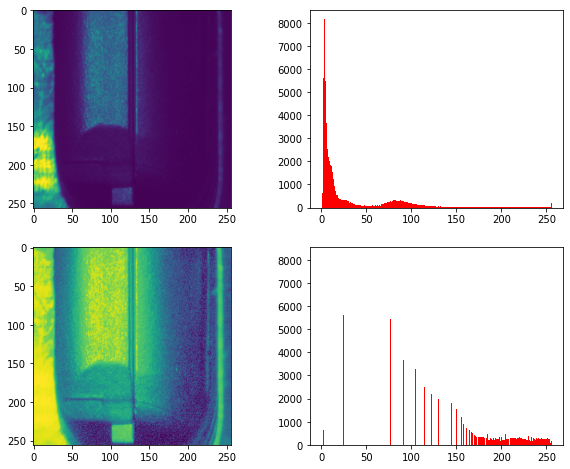

In [12]:
# Other Links of interest (adaptive threshold and histogram equalization)
# https://en.wikipedia.org/wiki/Adaptive_histogram_equalization
# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

# Huge thanks to: https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
# Note that we won't bother to record this hist, so we won't be able to restore the original (and that's totally fine)

# The masking steps are overly cautious...leaving them because the source did, and there may be
#   cornercase I haven't considered.

def equalize_histogram(img):
    """
    Expects a 2D image (remove any channel dims before passing in)
    """
    hist,bins = np.histogram(img.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum() # produce cumulative distribution function
    cdf = np.ma.masked_equal(cdf,0) # mask off any bin with 0 entries
    cdf = (cdf - cdf.min())*255//(cdf.max()-cdf.min()) # rescale to 0-255
    cdf = np.ma.filled(cdf,0) # fill mask with a designated value (0)
    equalized_img = cdf[img]
    return equalized_img

########## test ###########
# Create Image/Hist

eq_img = equalize_histogram(test_image)

# Display result
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8) )
ax00, ax01, ax10, ax11 = axes.flatten()

ax00.imshow(test_image)
ax01.hist(test_image.flatten(),256,[0,256], color = 'r')

ax10.imshow(eq_img)
ax11.hist(eq_img.flatten(),256,[0,256], color = 'r')
plt.show()


# Display Tools

In [13]:
# def find_reasonable_bounds(image, z_score=2):
#     mean = np.mean(image)
#     std_dev = np.std(image)
#     lower = mean - std_dev*z_score
#     upper = mean + std_dev*z_score
#     return (lower,upper)

In [14]:
def show_image_grid(images, labels = None, brightness = None, im_size=6):
    """
    Purpose:
        Helper function for displaying multiple images together in a grid.
    
    Inputs:
        images: A 2D grid of images with 2 non-squeezable dimensions: List(List(2D non-squeezable))
            This allows for inputs with batches and channel depth - they just squeeze out.
        labels: A 2D grid of labels (shape must match images).
        brightness: A 2D grid of brightness factors. This will scale the upper bound. 
            Default is None
            
            - This is useful if you wish all plots to use the same intensity scale.
        im_size: This can be used to scale images down. Most useful with 1-4 images, when they tend to scale up.
            - Warning: values >1 will prevent some data from being displayed, because the image grid will be
                       larger than the plot size allotted.
    
    Return: None
    """        
    n_rows = len(images)
    n_cols = len(images[0])
    brightness = np.ones((n_rows, n_cols)) if brightness is None else 1./np.array(brightness)
    
    show_title = False if labels is None else True
    labels = np.zeros((n_rows, n_cols)) if labels is None else labels
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(im_size*n_cols,im_size*n_rows)) # (20/n_images, 20/n_images))
    
    for ax_row, img_row, label_row, brightness_row in zip(axs, images, labels, brightness):
        for ax, img, label, brightness in zip(ax_row, img_row, label_row, brightness_row):
            img = np.squeeze(img)
#             img = img.astype(float)
            
            min_val = np.min(img)
            max_val = np.max(img)
            ax.imshow(img, vmin = np.min(img), vmax = min_val + brightness*(max_val - min_val))

            if(show_title):
                ax.set_title(label)
                ax.title.set_fontsize(3*im_size)
            
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            

# Quick Test
# image_grid = [[test_image, test_image, test_image], 
#               [eq_img, eq_img, eq_img]]
# scalars = [[1,2,10],[1,.5,.1]]
# show_image_grid(image_grid, label_grid, scalars)

# Load Images

TODO: Consider moving the function in this section to their own python file (the configuration should stay here though)

In [15]:
def read_image(img_dir, file_name, dsize = (256, 256)):
    img_path = os.path.join(img_dir, file_name)
    img = cv2.imread(img_path)
    return cv2.resize(img, dsize)

In [16]:
def preprocess_image(img):
    """
    Purpose: Reading and preprocessing combined in one method because we're avoiding generators at the moment, and 
    some of the input images may be large. By reading and scaling down immediately, we can keep memory
    manageable. Long-term, I may convert to generator expressions, but that's really not the point of this
    excercise.
    
    Inputs:
        src_dir: Directory to read images from
        dsize: target image size to scale to
        crop_dims: (top, bottom, left, right)
    """
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, dsize)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = equalize_histogram(img)
    img = img/256.
    img = np.expand_dims(img, -1)
    
    return img

In [17]:
nom_images = [read_image(nom_dir, file_name) for file_name in os.listdir(nom_dir)]
anom_images = [read_image(anom_dir, file_name) for file_name in os.listdir(anom_dir)]

nom_images = np.array([preprocess_image(img) for img in nom_images])
anom_images = np.array([preprocess_image(img) for img in anom_images])

nom_train_images, nom_test_images = train_test_split(nom_images, train_size=.8)

print("Shapes:")
print("nominal images: ", nom_images.shape)
print("nominal_train: ", nom_train_images.shape)
print("nominal_test: ", nom_test_images.shape)

print("\nanomalous images: ", anom_images.shape)
print("anomalous images are not split, because we won't be training with them.")

Shapes:
nominal images:  (147, 256, 256, 1)
nominal_train:  (117, 256, 256, 1)
nominal_test:  (30, 256, 256, 1)

anomalous images:  (146, 256, 256, 1)
anomalous images are not split, because we won't be training with them.


# Comparing Histograms of nominal / anomalous

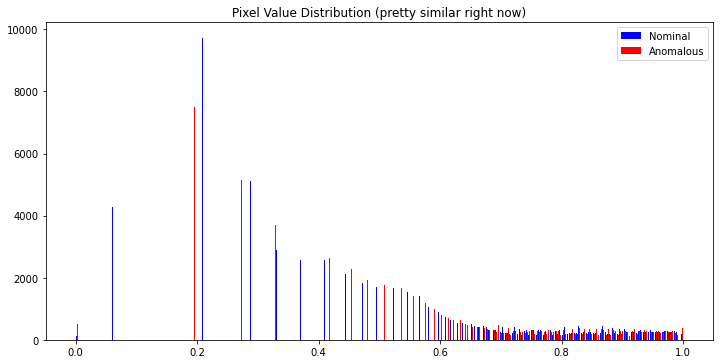

In [18]:
def plot_hist(ax, data, title):
    colors=['blue','red']
    labels=["Nominal", "Anomalous"]
    x_range = np.linspace(0, 1, 256)
    ax.hist(data, x_range, histtype='bar', color=colors, label=labels)
    ax.set_title(title)
    ax.legend(prop={'size': 10})
    
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5) )
fig.tight_layout()
    
data = [np.expand_dims(nom_train_images[0],0).flatten(), 
        np.expand_dims(anom_images[0],0).flatten()]
title = "Pixel Value Distribution (pretty similar right now)"

plot_hist(axes, data, title)
plt.show()

# Model

In [19]:
# Note: Default init is glorot_uniform, bias=zeros
model = Sequential([
    layers.BatchNormalization(input_shape = (256, 256, 1)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv1"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool1"),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv2"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool2"),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv3"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool3"),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="conv4"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool4"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv5"),
    layers.MaxPooling2D((2, 2), padding="same", name="pool5"),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same", name="convTrans5"),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans4"),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans3"),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans2"),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", name="convTrans1"),
    layers.BatchNormalization(),
    layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same", name="Channel_Reducer")
    ], name="AutoEncoder")

2022-06-14 17:34:14.982960: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3400040000 Hz
2022-06-14 17:34:14.983385: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fccbc000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-14 17:34:14.983410: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-14 17:34:15.073261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-14 17:34:15.073645: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bea067f6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-14 17:34:15.073679: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 3GB, Compute Capab

# Train

TODO: 
    - This section has some nice manual methods...it's just that there's such clean ones already built-in,
consider switching over...It will make: this cleaner, the output cleaner, easier to add callbacks and metrics, etc.
    - Consider adding saving along the way, either periodically, or for best, and maybe add early stopping (with a high-ish patience)

TODO: Isn't this preprocessing? Why do I have it here?

In [18]:
with tf.device('/GPU:0'):
    # Optimizer can be reset without resetting entire model (momentum for Adam will reset though)
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # .002 is 'sometimes' stable, meaning not really stable

    model.compile(optimizer=optimizer,
    #                   loss=tf.keras.losses.BinaryCrossentropy())
                      loss=tf.keras.losses.MeanSquaredError())
    # L1 would be reasonable too (literallly just |x-x_hat|)

In [19]:
# keras.utils.plot_model(model,
#                        show_shapes=True)
model.summary()

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 256, 256, 1)       4         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 32)      9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        

Rather than using plotting a test set, we're going to plot the anomalous image set.
In this case we want excessive overfitting, so that we can start to differentiate anomalous images.

In [20]:
# tf.config.run_functions_eagerly(True)
with tf.device('/GPU:0'):
    
    epochs = 300 # 5-8 epochs to show any intelligence, at least 30 for decent results, probably 75 for "good" numbers
    batch_size = 32
    # test_data = (np.expand_dims(nominal_test_images, -1), np.expand_dims(nominal_test_images, -1))
    anom_data = (anom_images, anom_images)

    training_hist = model.fit(x = nom_train_images,
                              y = nom_train_images,
                              epochs=epochs,
                              batch_size = batch_size,
                              shuffle=True,
                              validation_data=anom_data)

Epoch 1/300


2022-06-14 16:17:22.436317: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-14 16:17:23.118404: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-14 16:17:23.690962: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-14 16:17:23.759858: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 610.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-14 16:17:23.836440: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc)

3/4 [=====================>........] - ETA: 0s - loss: 0.1200

2022-06-14 16:17:25.249187: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.49GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


4/4 [==============================] - 3s 662ms/step - loss: 0.1151 - val_loss: 0.0715
Epoch 2/300
4/4 [==============================] - 1s 274ms/step - loss: 0.0678 - val_loss: 0.0714
Epoch 3/300
4/4 [==============================] - 1s 270ms/step - loss: 0.0406 - val_loss: 0.0714
Epoch 4/300
4/4 [==============================] - 1s 275ms/step - loss: 0.0326 - val_loss: 0.0714
Epoch 5/300
4/4 [==============================] - 1s 276ms/step - loss: 0.0265 - val_loss: 0.0715
Epoch 6/300
4/4 [==============================] - 1s 281ms/step - loss: 0.0211 - val_loss: 0.0717
Epoch 7/300
4/4 [==============================] - 1s 277ms/step - loss: 0.0169 - val_loss: 0.0719
Epoch 8/300
4/4 [==============================] - 1s 279ms/step - loss: 0.0138 - val_loss: 0.0720
Epoch 9/300
4/4 [==============================] - 1s 285ms/step - loss: 0.0115 - val_loss: 0.0721
Epoch 10/300
4/4 [==============================] - 1s 267ms/step - loss: 0.0099 - val_loss: 0.0722
Epoch 11/300
4/4 [===

4/4 [==============================] - 1s 272ms/step - loss: 0.0031 - val_loss: 0.0252
Epoch 84/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0032 - val_loss: 0.0238
Epoch 85/300
4/4 [==============================] - 1s 274ms/step - loss: 0.0032 - val_loss: 0.0215
Epoch 86/300
4/4 [==============================] - 1s 272ms/step - loss: 0.0032 - val_loss: 0.0215
Epoch 87/300
4/4 [==============================] - 1s 272ms/step - loss: 0.0032 - val_loss: 0.0198
Epoch 88/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0031 - val_loss: 0.0192
Epoch 89/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0031 - val_loss: 0.0184
Epoch 90/300
4/4 [==============================] - 1s 280ms/step - loss: 0.0031 - val_loss: 0.0184
Epoch 91/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0031 - val_loss: 0.0169
Epoch 92/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0031 - val_loss: 0.0165
Epoch 93/300


4/4 [==============================] - 1s 273ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 165/300
4/4 [==============================] - 1s 275ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 166/300
4/4 [==============================] - 1s 277ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 167/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 168/300
4/4 [==============================] - 1s 274ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 169/300
4/4 [==============================] - 1s 274ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 170/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 171/300
4/4 [==============================] - 1s 285ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 172/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 173/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0027 - val_loss: 0.0044
Epoc

4/4 [==============================] - 1s 272ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 246/300
4/4 [==============================] - 1s 274ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 247/300
4/4 [==============================] - 1s 274ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 248/300
4/4 [==============================] - 1s 274ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 249/300
4/4 [==============================] - 1s 274ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 250/300
4/4 [==============================] - 1s 276ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 251/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 252/300
4/4 [==============================] - 1s 281ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 253/300
4/4 [==============================] - 1s 268ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 254/300
4/4 [==============================] - 1s 273ms/step - loss: 0.0026 - val_loss: 0.0043
Epoc

TODO: Explore early stopping in the 25 to 75 epoch range (there is clearly a huge distinction between the populations...I played around briefly, and saw that the quality of the nominal output wasn't quite where I wanted, but it still might be an instructive tool and powerful anomaly detector

TODO: Play with regularization

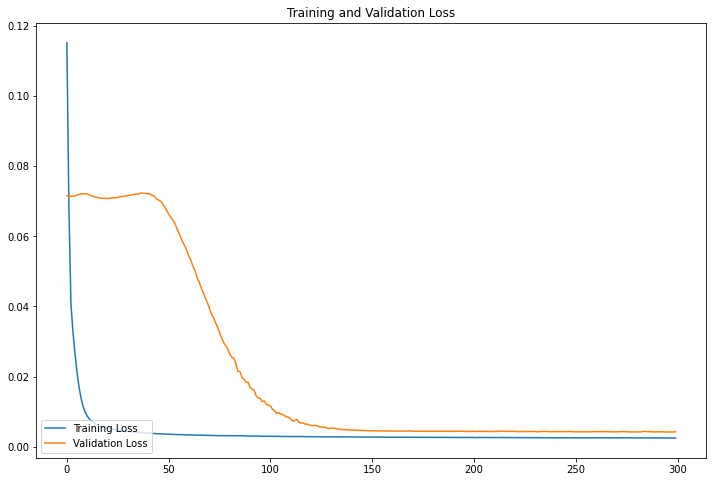

In [21]:
loss = training_hist.history['loss']
val_loss = training_hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,8))


# plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

# Save and Load

In [22]:
save_name = "temp" # "trained_with_batch_norm"

save_path = os.path.join("models/", save_name)
model.save(save_path) # I've got a decent model saved already
print("Saved model to: {save_path}")

2022-06-14 16:24:11.349946: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/temp/assets
Saved model to: {save_path}


In [20]:
!ls models


temp  trained_model  trained_with_batch_norm


In [21]:
load_name = 'temp' #'trained_with_batch_norm' # generally, don't overwrite the trained model unless we explicitly set the model to load
if load_name is not None:
    load_path = os.path.join("models/", load_name)
    model = tf.keras.models.load_model(load_path)
    model.summary()

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 256, 256, 1)       4         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 32)      9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        

In [22]:
# Todo: Use the loss I trained with 
#  I think I've switched back and forth so many times, just tinkering that I lost track...just define one and use it)
def find_loss_image(image1, image2): 
#     batch_size, height, width, channels = image1.shape
    loss_image = tf.losses.mean_squared_error(image1, image2)
    return loss_image

# Apply model and post-process results

TODO:
- Looking back at this, the reconstruction picks up 2 things:
    - All high frequency information (makes sense, since my resizing/pooling destroys some of that, since there are no residuals yet)
    - All unique features - that's the point, to find unique features such as welds/surface blemishes / etc.
- Consider leveraging the fact that all high frequency information is detected...
    - Adding residuals is probably the answer, but that's going to take some time to work out, esp. since the model is mostly using sequential API, not Functional (it will also carry more info through, and I might need to re-tune channel depth, and other stuff)
    - Quick-fix, it might help to just run a low-pass filter, so I don't have so much high frequency noise, or course that obviously compromises resolution
    
- Again, using 4 samples, which was nice in dev, but kind of confusing to anybody else reading through now

## Visualize Sample Image


# TODO: Denoising improvements
- could try this builtin cv2 func: new = cv2.fastNlMeansDenoising(trained_loss[0])

# Demonstrate key feature extraction with loss function
- Notably, there were a few other tequniques that worked well, and that I would have investigated more if this project had continued:
    - using division (which scales for brightness quite well)
    - absdiff (basically MAE)
- I also played with dynamic thresholding a bit, but in the end, I couldn't be sure my thresholds would generalize, because noise distributions might be different; however, for this application, the snippet below worked well.
```
trained_loss_flat = sorted(trained_loss[0].flatten())
thresh = trained_loss_flat[-10]
print("Thresh", thresh)
```

In [23]:
# Select images to demo in this notebook
nom_index = 50 # random.randrange(0, len(nom_train_images))
anom_index =  37 # random.randrange(0, len(anom_images))

nom_img = np.expand_dims(nom_train_images[nom_index],0)
anom_img = np.expand_dims(anom_images[anom_index],0)

print("Shapes: (keeping the batch and channel dimensions for easier prediction)")
print("nom_img images: ", nom_img.shape)
print("anom_img: ", anom_img.shape)

Shapes: (keeping the batch and channel dimensions for easier prediction)
nom_img images:  (1, 256, 256, 1)
anom_img:  (1, 256, 256, 1)


2022-06-14 17:34:45.715492: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-14 17:34:46.379305: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


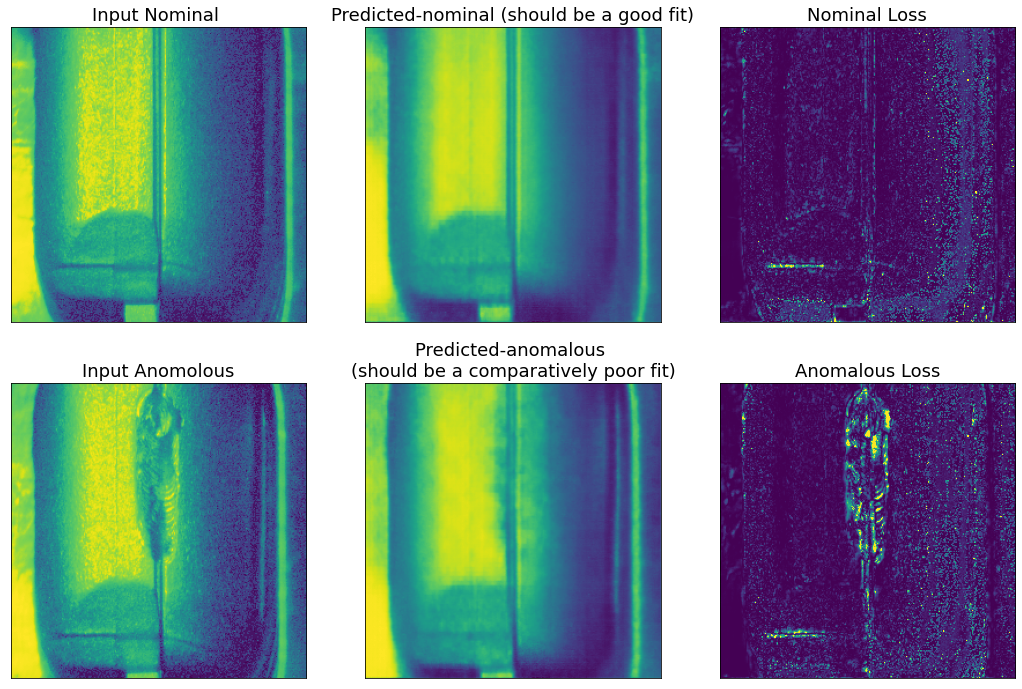

In [24]:
pred_nom_img = np.array(model(nom_img))
nom_loss = np.array(find_loss_image(nom_img, pred_nom_img))

pred_anom_img = np.array(model(anom_img))
anom_loss = np.array(find_loss_image(anom_img, pred_anom_img))

label_grid = [["Input Nominal ", "Predicted-nominal (should be a good fit)", "Nominal Loss"],
             ["Input Anomolous", "Predicted-anomalous \n(should be a comparatively poor fit)", "Anomalous Loss"]]

image_grid = [[nom_img, pred_nom_img, nom_loss], 
              [anom_img, pred_anom_img, anom_loss]]
show_image_grid(image_grid, label_grid, brightness = [[1,1,5],[1,1,5]])

# The plot below shows is beginning to show differences in the distributions
# we can create a metric that clearly distinguishes between distributions

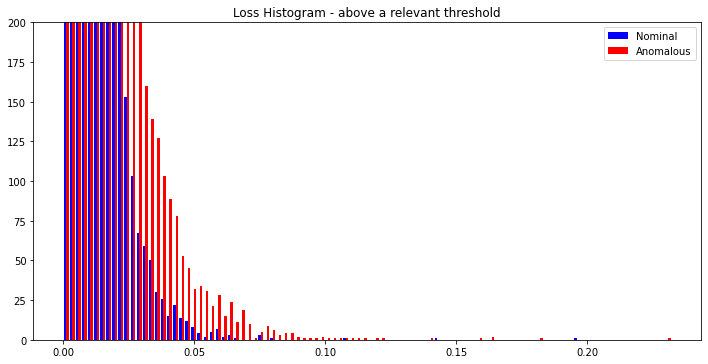

In [25]:
# Plot
# Reference: 
# https://matplotlib.org/2.0.2/examples/statistics/histogram_demo_multihist.html
# https://matplotlib.org/stable/plot_types/stats/hist2d.html?highlight=y%20range

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5) )
# ax0, ax1 = axes.flatten()
ax1 = axes 

fig.tight_layout()
data = [nom_loss.flatten(), anom_loss.flatten()]

colors = ['blue', 'red']
labels = ["Nominal", "Anomalous"]

bins = 100 # np.linspace(xmin, xmax, 30)
ax1.hist(data, bins, histtype='bar', color=colors, label=labels)
# ax1.hist(data, np.linspace(thresh/2, thresh, 30), histtype='bar', color=colors, label=labels)
ax1.set_title('Loss Histogram - above a relevant threshold')
ax1.legend(prop={'size': 10})
# ax1.set(xlim=(xmin, xmax))
ax1.set(ylim=(0, 200))

plt.show()

In [36]:
def connect_pixels(image, kernel = np.ones((5,5), np.uint8)):
    image = cv2.dilate(image, kernel, iterations=1)
    plt.imshow(image)
    image = cv2.erode(image, kernel, iterations=1)
    return image

In [38]:
def denoise(bin_image, min_cluster_size = 5):
    """
    Runs in O(n), where n is the number of pixels in the image.
    I explored some other tools, like erode / dilate, and a few others, but this is working well for now.
    """
    bin_image = bin_image.squeeze()
    height,width = bin_image.shape #256, 256
    image = bin_image.copy().flatten() # Create a copy (so we don't mess up the original)

    # initialize the visited array (0 for unvisited, -1 for unvisitable, aka bin_image is already 0 there)
    UNEXPLORED = -1
    IMAGE_0 = -2
    
    visited = np.ones(image.shape)*IMAGE_0 # nothing explored yet
    idx = (image[:] != 0)
    visited[idx] = UNEXPLORED

    for search_index in range(image.shape[0]):
        # print(f"{search_index}/{image.shape[0]}")
        frontier = set([search_index]) # initialize with current item
        this_cluster = []
        pixels_in_cluster = 0
        while frontier:
            # print(f"Frontier: {frontier}")
            pixel_index = frontier.pop()
            if visited[pixel_index] == UNEXPLORED:
                visited[pixel_index] = search_index # set the group ID of this pixel to the index that started this DFS
                pixels_in_cluster += 1

                # Add the graph's edges
                if pixel_index >= width:  # up
                    frontier.add(pixel_index - width)
                if pixel_index < width * (height - 1):  # down
                    frontier.add(pixel_index + width)
                if pixel_index % width != 0:  # left
                    frontier.add(pixel_index - 1)
                if pixel_index % width != (width - 1):  # right
                    frontier.add(pixel_index + 1)

                this_cluster.append(pixel_index)

        if pixels_in_cluster < min_cluster_size:
            image[this_cluster] = 0

    image = image.reshape(height,width)
    
    # TODO: Experimental line
    image = connect_pixels(image)
            
    return image

In [39]:
thresh = 0.015 # threshold for binarization
min_pixels_per_cluster = 10 # threshold for cluster size in post-process denoising

Loss on trained image: 0.0022
Loss on unfit image: 0.0316
{v}: Unfit image missed 14.40 times as much information.
0.19523972


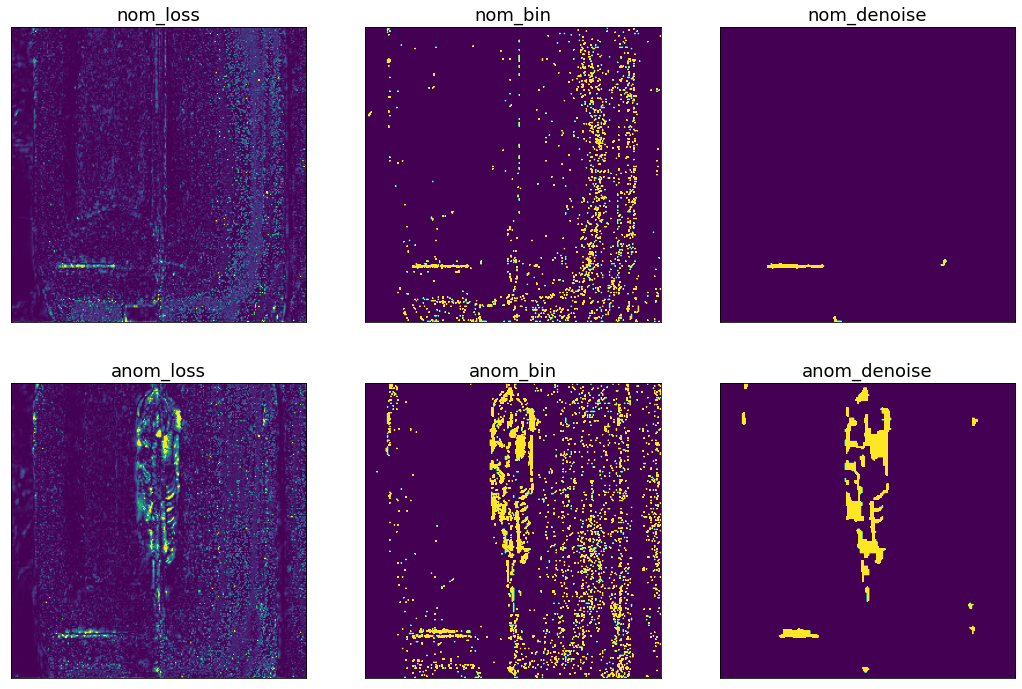

In [42]:
nom_bin = binarize(nom_loss, thresh)

anom_bin = binarize(anom_loss, thresh)

###########################################################################
label_grid = [["nom_loss", "nom_bin", "nom_denoise"],
              ["anom_loss", "anom_bin", "anom_denoise"]]

image_grid = [[nom_loss, nom_bin, nom_denoise],
              [anom_loss, anom_bin, anom_denoise]]

brightness = [[5,5,5],
              [5,5,5]]


print("Loss on trained image: %0.4f" %  np.mean(nom_denoise))
print("Loss on unfit image: %0.4f" % np.mean(anom_denoise))
print("{v}: Unfit image missed %0.2f times as much information." % (np.mean(anom_denoise)/np.mean(nom_denoise)) ) 


show_image_grid(image_grid, label_grid, brightness) 
print(np.max(nom_loss))

# TODO
Add a set of images for nom and anom showing
- loss image
- Thresholded loss image
- Thresholded loss image with denoising

# Show extracted pixels overlaid on top of original

In [43]:
def post_process(input_img, predicted_im, thresh, min_pixels_per_cluster, crop_dims=None, ): 
    loss_im = np.array(find_loss_image(input_img, predicted_im))
    bin_img = binarize(loss_im, thresh)
    denoised_image = denoise(bin_img, min_pixels_per_cluster)
    
    if crop_dims is not None:
        denoised_image = denoised_image[crop_dims[0]:crop_dims[1]][crop_dims[2]:crop_dims[3]]

    return denoised_image

Loss on trained image: 0.0022
Loss on unfit image: 0.0316
Unfit image missed 14.40 times as much information.


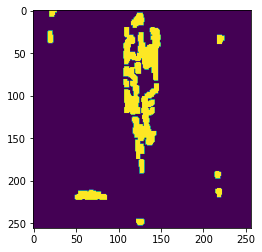

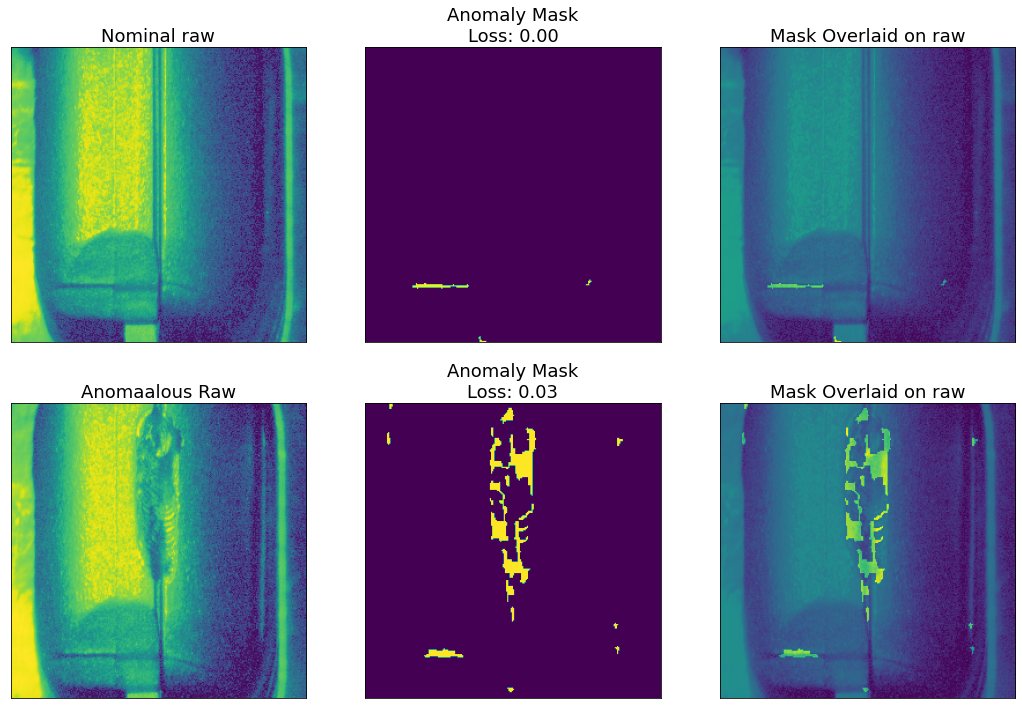

In [44]:
post_nom_im = post_process(nom_img, pred_nom_img, thresh, min_pixels_per_cluster)
post_anom_im = post_process(anom_img, pred_anom_img, thresh, min_pixels_per_cluster)

# print(post_trained_im[0].shape)
trained_mean_loss = np.mean(post_nom_im)
anomalous_mean_loss = np.mean(post_anom_im)

image_grid = [[nom_img, post_nom_im, np.squeeze(nom_img)+np.squeeze(post_nom_im)],
              [anom_img, post_anom_im, np.squeeze(anom_img)+np.squeeze(post_anom_im)]]

label_grid = [["Nominal raw", "Anomaly Mask\nLoss: %0.2f" % trained_mean_loss, "Mask Overlaid on raw"],
             ["Anomaalous Raw", "Anomaly Mask\nLoss: %0.2f" % anomalous_mean_loss, "Mask Overlaid on raw"]]

print("Loss on trained image: %0.4f" % trained_mean_loss)
print("Loss on unfit image: %0.4f" % anomalous_mean_loss)
print("Unfit image missed %0.2f times as much information." % (anomalous_mean_loss/trained_mean_loss) ) 

show_image_grid(image_grid, label_grid)


# Summary and Analysis (Averaged over entire dataset)

In [45]:
def process_images(images, crop_dims=None, batch_size=32, preprocess=False):
    total_length = len(images)
    
    if crop_dims is not None:
        print("Cropping images:", crop_dims)
    
    num_batches = total_length // batch_size
    if total_length % batch_size != 0: # the partial batch
        num_batches += 1
    
    detection_maps = []
    for batch_num in range(num_batches):
        batch_start = batch_num*batch_size
        if batch_start + batch_size < total_length:
            batch_end = batch_start + batch_size
        else:
            batch_end = total_length-1
        print(f"Processing images [{batch_start},{batch_end})")
            
        input_images = images[batch_start:batch_end]
        if preprocess:
            input_images = np.array([preprocess_image(img) for img in batch_images])
        pred_images = model.predict(input_images)
        detection_maps += [post_process(input_img, pred_img, thresh, min_pixels_per_cluster) for input_img, pred_img in zip(input_images, pred_images)]

    return np.array(detection_maps)


Processing images [0,32)


2022-06-14 17:40:45.157683: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Processing images [32,64)
Processing images [64,96)
Processing images [96,116)
Processing images [0,32)
Processing images [32,64)
Processing images [64,96)
Processing images [96,128)
Processing images [128,145)


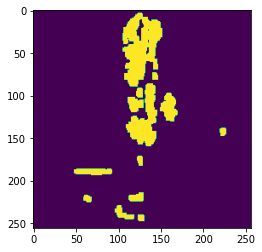

In [46]:
nom_detection_maps = process_images(nom_test_images)  
anom_detection_maps = process_images(anom_images)

nom_losses = np.mean(nom_detection_maps, (1,2))
anom_losses = np.mean(anom_detection_maps, (1,2))

### Plot Resulting Distributions

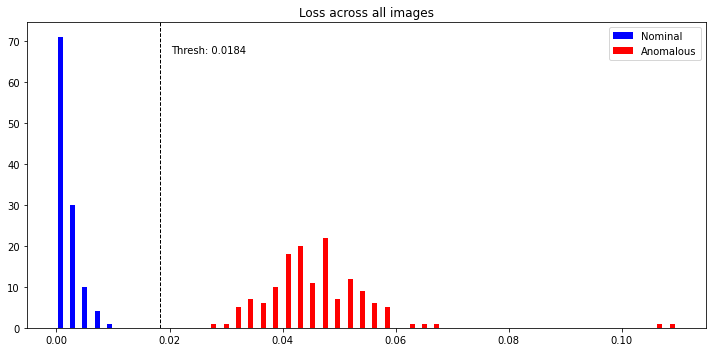

In [47]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = axes

data = [nom_losses, anom_losses]
bins = 50
colors = ["blue","red"]
labels = ["Nominal", "Anomalous"]
ax.hist(data, bins, histtype='bar', color=colors, label=labels)


thresh = np.mean((np.max(nom_losses),np.min(anom_losses)))
ax.axvline(thresh, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(thresh*1.1, max_ylim*0.9, 'Thresh: {:.4f}'.format(thresh))

ax.set_title('Loss across all images')
ax.legend(prop={'size': 10})

fig.tight_layout()

plt.show()

In [48]:
# Set a threshold 
# Used during development to find extreme images - this allowed me to tune the model
delta = .002
for i, v in enumerate(nom_losses):
    if v > thresh - delta:
        print("Bad Nominal: ", v, ":", i)
for i, v in enumerate(anom_losses):
    if v < thresh + delta: 
        print("Bad anomalous: ", v, ":", i)

## How to set the threshold?
We have a lot of ways to evaluate the model, and the ideal threshold. We commonly try to summarize with a single value (such as F1 score, or area under the precision-recall curve, or a ROC curve. I'll look at a few of those below, but it quickly becomes obvious that they aren't very useful in applications that require extremely reliable detection of defects.

### Extrapolate distributions with statistics
In this example, we have __perfect__ characterization. That's very common with smaller sample sizes, and we will simply extrapolate using statistics, and using ratios with a cdf function.
__You should ensure all data are normal before performing this analysis__. Just eyeballing it, I can tell my data are not normally distributed, and would require a transform for their distribtuions to become normal. I may do that in the future, but for now, it's out of scope. Obviously, we'd perform a deeper analysis before actually relying on this.
[Learn more here](https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/)

### Safety Critical Applications have different priorities
When it comes to safety critical applications, we're very concerned about escapes (false negatives). Escapes kill people, whereas False positives add a couple minutes of manual verification. Therefore, we'll set our threshold based on the anomalous group. We count standard deviations from the mean of the anomalous group. Best practices vary from 3-6 standard deviations, based on how critical a defect is, industry, and company policy. However, 4 is a good starting point, and that's what I'll use here.

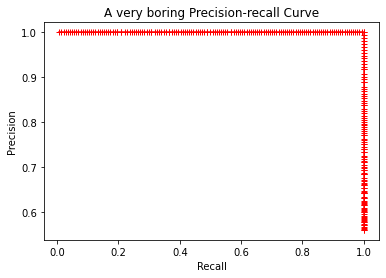

In [49]:
# Plot Raw Precision-Recall Curve
def generate_precision_recall_curve(negatives, positives):
    """
    This function assumes values above the threshold are positive, and values below the threshold are negative.
    """
    thresholds = sorted(list(negatives) + list(positives))
    
    precision = []
    recall = []
    for thresh in thresholds:
        true_pos = np.count_nonzero(positives > thresh)
        false_neg = np.count_nonzero(positives < thresh)
        false_pos = np.count_nonzero(negatives > thresh)
        if true_pos + false_pos != 0 and true_pos + false_neg != 0:
            precision.append(true_pos / (true_pos + false_pos) )
            recall.append(true_pos / (true_pos + false_neg) )
        
    plt.plot(recall, precision, 'r-+')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("A very boring Precision-recall Curve")
        
generate_precision_recall_curve(nom_losses, anom_losses)

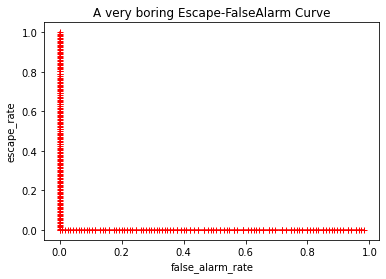

In [50]:
# escape rate vs. false alarm rate 
def generate_false_alarm_escape_curve(negatives, positives, threshold_samples):
    """
    This function assumes values above the threshold are positive, and values below the threshold are negative.
    """
    false_alarm_rate = []
    escape_rate = []
    for thresh in threshold_samples:
        true_pos = np.count_nonzero(positives > thresh)
        true_neg = np.count_nonzero(negatives < thresh)
        false_pos = np.count_nonzero(negatives > thresh)
        false_neg = np.count_nonzero(positives < thresh)
        
        false_alarm_rate.append(false_pos / (false_pos + true_neg))
        escape_rate.append(false_neg / (false_neg + true_pos))
        
    plt.plot(false_alarm_rate, escape_rate, 'r-+')
    plt.xlabel("false_alarm_rate")
    plt.ylabel("escape_rate")
    plt.title("A very boring Escape-FalseAlarm Curve")

        
thresholds = sorted(list(nom_losses) + list(anom_losses))[2:]
generate_false_alarm_escape_curve(nom_losses, anom_losses, thresholds)


escape_rate, false_alarm_rate
z_thresh: -4.00, thresh_val: 0.0044, x: 0.0032%, y: 12.92%
z_thresh: -3.80, thresh_val: 0.0064, x: 0.0072%, y: 1.22%
z_thresh: -3.60, thresh_val: 0.0085, x: 0.0159%, y: 0.04%
z_thresh: -3.40, thresh_val: 0.0106, x: 0.0337%, y: 0.00%
z_thresh: -3.20, thresh_val: 0.0126, x: 0.0687%, y: 0.00%
z_thresh: -3.00, thresh_val: 0.0147, x: 0.1350%, y: 0.00%

recall, precision
z_thresh: -4.00, thresh_val: 0.0044, x: 99.9968%, y: 88.56%
z_thresh: -3.80, thresh_val: 0.0064, x: 99.9928%, y: 98.79%
z_thresh: -3.60, thresh_val: 0.0085, x: 99.9841%, y: 99.96%
z_thresh: -3.40, thresh_val: 0.0106, x: 99.9663%, y: 100.00%
z_thresh: -3.20, thresh_val: 0.0126, x: 99.9313%, y: 100.00%
z_thresh: -3.00, thresh_val: 0.0147, x: 99.8650%, y: 100.00%


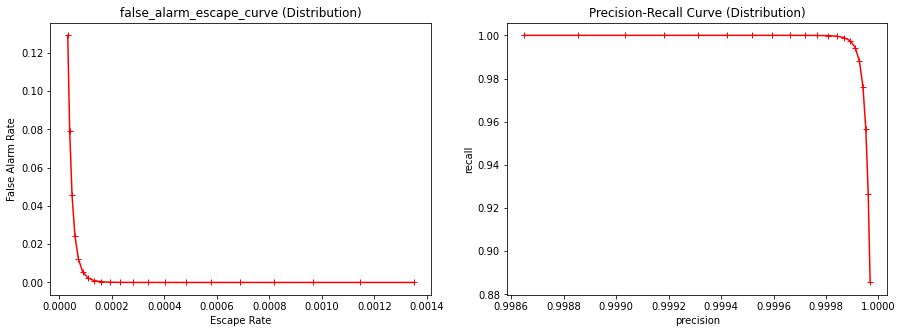

In [51]:
# escape rate vs. false alarm rate 
def precision(true_pos, true_neg, false_pos, false_neg):
    return true_pos / (true_pos + false_pos)
def recall(true_pos, true_neg, false_pos, false_neg):
    return true_pos / (true_pos + false_neg)
def sensitivity(true_pos, true_neg, false_pos, false_neg):
    return true_pos / (true_pos + false_neg)
# def specificity():
def false_alarm_rate(true_pos, true_neg, false_pos, false_neg):
    return false_pos / (false_pos + true_neg)
def escape_rate(true_pos, true_neg, false_pos, false_neg):
    return false_neg / (false_neg + true_pos)


def generate_sampled_gaussian_plot(negatives, positives, x_function, y_function):
    """
    This function assumes values above the threshold are positive, and values below the threshold are negative.
    """
    pos_mean = np.mean(positives)
    pos_std_dev = np.std(positives)
#     print(f"Distribution for positive (nominal) data: u={pos_mean}, sigma={pos_std_dev}")
    
    neg_mean = np.mean(negatives)
    neg_std_dev = np.std(negatives)
#     print(f"Distribution for negative (anomalous) data:  u={neg_mean}, sigma={neg_std_dev}")

    steps = 21
    z_threshholds = np.linspace(-4, -3, steps)
    
    x = []
    y = []
    print(f"\n{x_function.__name__}, {y_function.__name__}")
    for i, z_thresh in enumerate(z_threshholds):
#         z_pos = (thresh - pos_mean) / pos_std_dev
        true_pos = 1 - scipy.stats.norm.cdf(z_thresh)
        false_neg = 1 - true_pos 
        
        thresh_val = pos_mean + z_thresh*pos_std_dev
        z_neg = (thresh_val - neg_mean) / neg_std_dev
        true_neg = scipy.stats.norm.cdf(z_neg)
        false_pos = 1 - true_neg 
        
        x.append(x_function(true_pos, true_neg, false_pos, false_neg))
        y.append(y_function(true_pos, true_neg, false_pos, false_neg))
        if i %4 == 0:
            print(f"z_thresh: {z_thresh:.2f}, thresh_val: {thresh_val:.4f}, x: {x[-1]*100:.4f}%, y: {y[-1]*100:.2f}%")
        
    return x, y 

def plot_precision_recall_curve(negatives, positives, ax):
    x,y = generate_sampled_gaussian_plot(negatives, positives, recall, precision)
    ax.plot(x, y, 'r-+') #, cpk4_x, cpk4_y, 'bo')
    ax.set_xlabel("precision")
    ax.set_ylabel("recall")
    ax.set_title("Precision-Recall Curve (Distribution)")
    
def roc_curve(negatives, positives, ax):
    x,y = generate_sampled_gaussian_plot(negatives, positives, false_alarm_rate, sensitivity)
    ax.plot(x, y, 'r-+') # , cpk4_x, cpk4_y, 'bo')
    ax.set_xlabel("True Positive Rate")
    ax.set_ylabel("False Alarm Rate")
    ax.set_title("ROC Curve (Distribution)")
    
def false_alarm_escape_curve(negatives, positives, ax):
    x,y = generate_sampled_gaussian_plot(negatives, positives, escape_rate, false_alarm_rate)
    ax.plot(x, y, 'r-+') # , cpk4_x, cpk4_y, 'bo')
    ax.set_xlabel("Escape Rate")
    ax.set_ylabel("False Alarm Rate")
    ax.set_title("false_alarm_escape_curve (Distribution)")
    
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5) )
ax0, ax1 = axes.flatten()

false_alarm_escape_curve(nom_losses, anom_losses, ax0)
plot_precision_recall_curve(nom_losses, anom_losses, ax1)


Looking at the False Alarm vs. Escape, we can get a good idea of where to set the threshold for different applications.
- For safety critical tests: This detector is not ready for safety critical evaluation on this application 
    - We would set it to 4 standard deviations, missing only .0032% of escapes
    - However, we would be overwhelmed by a 56% False alarm rate!
    - Additional improvements needed
- For less critical tests (such as visual defects): This would be fantastic for less critical applications, finding visual defects
    - We could catch nearly 99.9% of issues, and only trigger false positives 0.02% of the time
    - Because this is a very general application, we can find defects anywhere in the image
- Offline assessment

### How to improve the model?
#### Low Hanging Fruit (crop)
For specific safety critical failures, we usually know exactly which failure we're looking for and where to find it. 
We trained this model on the nominal dataset only, and then treated the welded data as the defect. This is a bit artificial;
however, we can use it to show the extra power our model gains when we know exactly where to look.

The analysis below crops the welded region, focusing in just the spot we care about, and the numbers get **much** better.

#### Additional Improvements
- Augment Data: Primarily x and y offset, since the main errors the model still shows are in the slight offsets in extreme bright/dark transitions
- Increase the amount of training data
- Train longer (training had nearly plateaud, but we could probably get a little more performance, and we actively want a degree of overfitting, so there's no need to worry about that

Cropping images: (0, 255, 50, -25)
Processing images [0,29)


2022-06-14 17:43:45.426258: W tensorflow/core/common_runtime/bfc_allocator.cc:245] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Cropping images: (0, 255, 50, -25)
Processing images [0,32)
Processing images [32,64)
Processing images [64,96)
Processing images [96,128)
Processing images [128,145)

escape_rate, false_alarm_rate
z_thresh: -4.00, thresh_val: 0.0018, x: 0.0032%, y: 39.03%
z_thresh: -3.80, thresh_val: 0.0036, x: 0.0072%, y: 8.24%
z_thresh: -3.60, thresh_val: 0.0053, x: 0.0159%, y: 0.62%
z_thresh: -3.40, thresh_val: 0.0071, x: 0.0337%, y: 0.02%
z_thresh: -3.20, thresh_val: 0.0088, x: 0.0687%, y: 0.00%
z_thresh: -3.00, thresh_val: 0.0105, x: 0.1350%, y: 0.00%

recall, precision
z_thresh: -4.00, thresh_val: 0.0018, x: 99.9968%, y: 71.93%
z_thresh: -3.80, thresh_val: 0.0036, x: 99.9928%, y: 92.38%
z_thresh: -3.60, thresh_val: 0.0053, x: 99.9841%, y: 99.38%
z_thresh: -3.40, thresh_val: 0.0071, x: 99.9663%, y: 99.98%
z_thresh: -3.20, thresh_val: 0.0088, x: 99.9313%, y: 100.00%
z_thresh: -3.00, thresh_val: 0.0105, x: 99.8650%, y: 100.00%


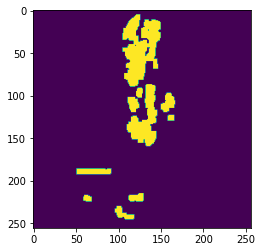

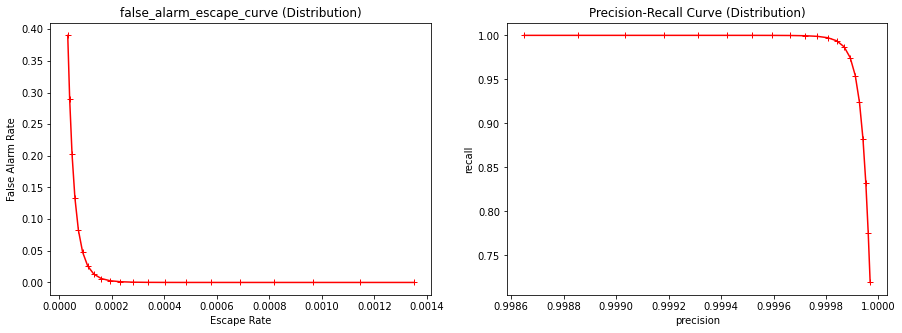

In [54]:
top, bottom, left, right  = 0, 255, 50, -25
crop_dims = (top, bottom, left, right)

nom_detection_maps = process_images(nom_test_images, crop_dims)  
anom_detection_maps = process_images(anom_images, crop_dims)

nom_losses = np.mean(nom_detection_maps, (1,2))
anom_losses = np.mean(anom_detection_maps, (1,2))
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5) )
ax0, ax1 = axes.flatten()

false_alarm_escape_curve(nom_losses, anom_losses, ax0)
plot_precision_recall_curve(nom_losses, anom_losses, ax1)


In [55]:
bad_thresh = sorted(nom_losses, reverse=True)[5]
bad_indexes = [i  for i,loss in enumerate(nom_losses) if loss > bad_thresh] 
print(bad_indexes)


[5, 7, 11, 16, 23]


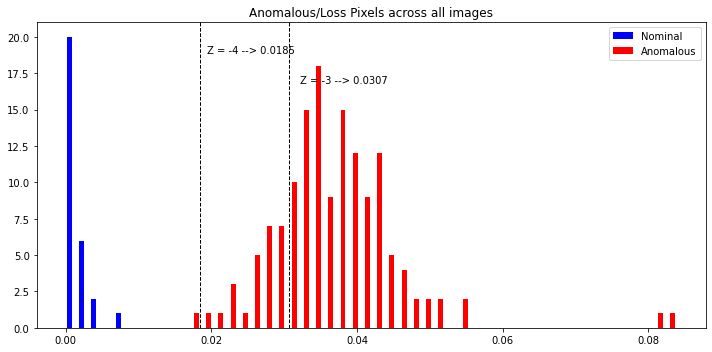

In [56]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax = axes # ax = axes.flatten()

data = [nom_losses, anom_losses]
bins = 50
colors = ["blue","red"]
labels = ["Nominal", "Anomalous"]
ax.hist(data, bins, histtype='bar', color=colors, label=labels)

thresh = 0.0185 # @ z = -4
ax.axvline(thresh, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(thresh*1.05, max_ylim*0.9, 'Z = -4 --> {:.4f}'.format(thresh))

thresh = 0.0307 # @ z = -3
ax.axvline(thresh, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(thresh*1.05, max_ylim*0.8, 'Z = -3 --> {:.4f}'.format(thresh))

ax.set_title('Anomalous/Loss Pixels across all images')
ax.legend(prop={'size': 10})

fig.tight_layout()

plt.show()



# Conclusion
### Proof of concept for a generalized defect detector?
We've certainly demonstrated viability, with 2 clearly distinct distributions, we've succeeded in detected the differences in these images

### Appropriate for safety critical applications?
Yes, mostly. This model is seeing 2% false alarm rates. That means we've reduced 98% of the manual work with this general application. We could still improve further, but this is arguably ready for use. 

### Appropriate for finding visual defects (not safety critical)?
Absolutely. Setting a threshold of .0296, this model finds 99.9% of issues, with only 0.02% false alarm rate. 

# See readme for next steps in this project...
There are a handful of features that would be fun to explore, but this satisfies the original scope of this project.